# Convolutional Spam Classifier

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext.legacy import data
from torchtext.legacy import datasets
import random
import numpy as np
import spacy
import torch.optim as optim
import time
from matplotlib.ticker import PercentFormatter
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

#SEED1 = np.random.randint(9999)
#SEED2 = np.random.randint(9999)
SEED1 = 571
SEED2 = 9801
torch.backends.cudnn.deterministic = True # allow reproduction of results on different devices

## 1. Data Preparation

Import and split Data

In [2]:
TEXT = data.Field(tokenize = 'spacy', tokenizer_language = 'en_core_web_sm', batch_first = True)  
LABEL = data.LabelField(dtype = torch.float)
fields = [(None, None), ('text', TEXT), ('label', LABEL)]
dataset = data.TabularDataset.splits(   path = 'data',
                                        train = 'spam.csv',
                                        format = 'csv',
                                        fields = fields,
                                        skip_header = True)[0]

trainValid_data, test_data = dataset.split(split_ratio=0.85, random_state = random.seed(SEED1))
train_data, valid_data = trainValid_data.split(split_ratio=0.7/0.85, random_state = random.seed(SEED2))

Build vocab and create iterators

In [20]:
TEXT.build_vocab(train_data, max_size = 25000)
LABEL.build_vocab(train_data)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_itr, valid_itr, test_itr = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    sort = False,
    batch_size = 64,
    device = device)

## 2. Build the Model

In [21]:
class CNN(nn.Module):
    def __init__(self, vocab_size, emb_dim, num_filter, filter_sizes, dropout, pad_idx):
        super().__init__()
        # Embedding Layer
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx = pad_idx)
        # Convolutional Layer
        self.convs = nn.ModuleList([nn.Conv2d(in_channels = 1, 
                                              out_channels = num_filter, 
                                              kernel_size = (filter_size, emb_dim)) 
                                    for filter_size in filter_sizes])
        # Fully Connected Linear Layer
        self.fc = nn.Linear(len(filter_sizes)*num_filter, 1) # output_dim = 1
        # Dropout for Regularization
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        # embed: [batch_size=64, 1, sentence len, emb_dim=100]
        embed = self.embedding(text).unsqueeze(1)
        # conved: [batch_size=64, nun_filter, len(sentence)-filter_sizes[n]+1]
        conved = [F.relu(cv(embed)).squeeze(3) for cv in self.convs]
        # max pool respect to sentence
        # pooled: [batch size=64, num_filter]
        pooled = [F.max_pool1d(cvd, cvd.shape[2]).squeeze(2) for cvd in conved]
        # concat: [batch size=64, num_filter * len(filter_sizes)]
        concat = self.dropout(torch.cat(pooled, dim = 1))
        return self.fc(concat)

Create an instance of CNN class

In [22]:
# CNN(vocab_size, emb_dim, num_filter, filter_sizes, dropout, pad_idx)
model = CNN(len(TEXT.vocab), 100, 512, [2,3,4,5,6,7,8,9], 0.5, TEXT.vocab.stoi[TEXT.pad_token])

## 3. Initialize Embedding
Initialize word embedding with zeros

In [23]:
model.embedding.weight.data = torch.zeros((len(TEXT.vocab), 100))
model.embedding.weight.data[TEXT.vocab.stoi[TEXT.unk_token]] = torch.zeros(100)
model.embedding.weight.data[TEXT.vocab.stoi[TEXT.unk_token]] = torch.zeros(100)

## 4. Training

Initialize optimizer and loss function and place it to the device

In [24]:
optimizer = optim.Adam(model.parameters())
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
criterion = criterion.to(device)

Define a function for training which returns loss and accuracy

In [25]:
def train(model, iterator, optimizer, criterion):
    loss_ep = 0
    acc_ep = 0
    model.train()
    for batch in iterator:
        optimizer.zero_grad()
        preds = model(batch.text).squeeze(1)
        loss = criterion(preds, batch.label)
        acc = sum((torch.round(torch.sigmoid(preds)) == batch.label).float())/len(preds)
        loss.backward()
        optimizer.step()
        loss_ep += loss.item()
        acc_ep += acc.item()
    loss_avg = loss_ep/len(iterator)
    acc_avg = acc_ep/len(iterator)
    return loss_avg, acc_avg

Define a function for evaluation

In [26]:
def evaluate(model, iterator, criterion):
    loss_ep = 0
    acc_ep = 0
    model.eval()
    with torch.no_grad():
        for batch in iterator:
            preds = model(batch.text).squeeze(1)
            loss = criterion(preds, batch.label)
            acc = sum((torch.round(torch.sigmoid(preds)) == batch.label).float())/len(preds)
            loss_ep += loss.item()
            acc_ep += acc.item()
    loss_avg = loss_ep/len(iterator)
    acc_avg = acc_ep/len(iterator)
    return loss_avg, acc_avg

Define a function to measure time elapsed

In [27]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Training, takes several minutes

In [28]:
num_epoch = 5
best_valid_loss = float('inf')
acc_training = []
loss_training = []
acc_validation = []
loss_validation = []

for epoch in range(1, num_epoch+1):
    start_time = time.time()
    loss_train, acc_train = train(model, train_itr, optimizer, criterion)
    loss_valid, acc_valid = evaluate(model, valid_itr, criterion)
    acc_training.append(acc_train)
    loss_training.append(loss_train)
    acc_validation.append(acc_valid)
    loss_validation.append(loss_valid)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    if loss_valid < best_valid_loss:
        best_valid_loss = loss_valid
        torch.save(model.state_dict(), 'spam-model.pt')
    
    print(f'Epoch: {epoch}')
    print(f'\tTrain Loss: {loss_train:.4f}, Train Accuracy: {acc_train*100:.2f}%')
    print(f'\tValid Loss: {loss_valid:.4f}, Valid Accuracy: {acc_valid*100:.2f}%')
    print(f'\tEpoch Time: {epoch_mins}m {epoch_secs}s')
    #print(model.embedding.weight.data)

Epoch: 1
	Train Loss: 0.3086, Train Accuracy: 89.16%
	Valid Loss: 0.0654, Valid Accuracy: 97.88%
	Epoch Time: 1m 22s
Epoch: 2
	Train Loss: 0.0317, Train Accuracy: 99.08%
	Valid Loss: 0.0400, Valid Accuracy: 98.77%
	Epoch Time: 1m 24s
Epoch: 3
	Train Loss: 0.0041, Train Accuracy: 99.87%
	Valid Loss: 0.0405, Valid Accuracy: 98.66%
	Epoch Time: 1m 19s
Epoch: 4
	Train Loss: 0.0008, Train Accuracy: 100.00%
	Valid Loss: 0.0434, Valid Accuracy: 98.33%
	Epoch Time: 1m 20s
Epoch: 5
	Train Loss: 0.0004, Train Accuracy: 100.00%
	Valid Loss: 0.0459, Valid Accuracy: 98.33%
	Epoch Time: 1m 23s


## 5. Result & Analysis
Here is the loss and accuracy for test set

In [29]:
model.load_state_dict(torch.load('spam-model.pt'))
loss_test, acc_test = evaluate(model, test_itr, criterion)
print(f'\tTest Loss: {loss_test:.4f}, Test Accuracy: {acc_test*100:.2f}%')

	Test Loss: 0.0438, Test Accuracy: 98.77%


Plot training result

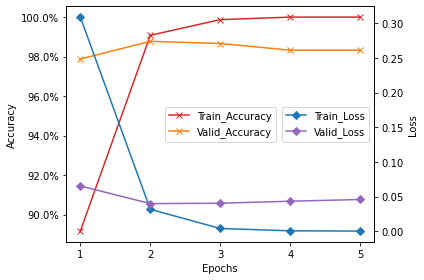

In [30]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.plot(np.arange(1,6), 100*np.array(acc_training), color='tab:red', marker = 'x')
ax1.plot(np.arange(1,6), 100*np.array(acc_validation), color='tab:orange', marker = 'x')
ax1.tick_params(axis='y')
plt.legend(['Train_Accuracy','Valid_Accuracy'], loc='center')
ax1.yaxis.set_major_formatter(PercentFormatter())

ax2 = ax1.twinx()
ax2.set_ylabel('Loss')
ax2.plot(np.arange(1,6), np.array(loss_training), color='tab:blue', marker='D')
ax2.plot(np.arange(1,6), np.array(loss_validation), color='tab:purple', marker='D')
ax2.tick_params(axis='y')

plt.xticks([1,2,3,4,5])
plt.legend(['Train_Loss','Valid_Loss'], loc='right')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Plot word embedding with the help of SVD

In [31]:
def reduce_to_k_dim(M, k): 
    n_iters = 10
    M_reduced = None
    M_reduced = TruncatedSVD(n_components = k).fit_transform(M)
    return M_reduced

def plot_embedding(M_embedding, words):
    xs = [row[0] for row in M_embedding]
    ys = [row[1] for row in M_embedding]
    for i, word in enumerate(words):
        x = xs[i]
        y = ys[i]
        plt.scatter(x, y, marker='x', color='red')
        plt.text(x, y, word)
    plt.show()

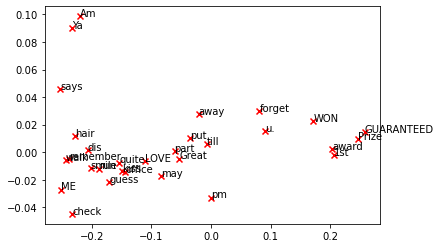

In [32]:
tensor_2d = reduce_to_k_dim(model.embedding.weight.data, 2)
tensor2dArray = np.array(tensor_2d.tolist())
    
word_by_idx = vars(TEXT.vocab)['itos']
plot_embedding(tensor2dArray[500:530,:], word_by_idx[500:530])